## Multimodal Emotion Detection System

In [1]:
#import libraries
import os
import numpy as np
import librosa
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate, Conv2D, MaxPooling2D, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Importing necessary libraries for facial expression recognition
import cv2

In [2]:
# Data Preparation for Voice Tone Analysis Model (TESS Dataset)
audio_data_directory = "TESS/"
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

audio_features = []
audio_labels = []


In [3]:
# Loop through each emotion and load corresponding audio files
for emotion in emotions:
    for audio_file in os.listdir(audio_data_directory):
        if emotion in audio_file:
            audio_path = os.path.join(audio_data_directory, audio_file)
            # Load audio file and extract features using librosa
            y, sr = librosa.load(audio_path, sr=None)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            mfccs_mean = np.mean(mfccs.T, axis=0)
            audio_features.append(mfccs_mean)
            audio_labels.append(emotion)


In [4]:
# Convert features and labels to numpy arrays
audio_features = np.array(audio_features)
audio_labels = np.array(audio_labels)

In [5]:
from sklearn.preprocessing import LabelEncoder
# Encode labels
label_encoder = LabelEncoder()
audio_labels_encoded = label_encoder.fit_transform(audio_labels)
num_classes = len(label_encoder.classes_)

In [6]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and validation sets
audio_train, audio_validation, labels_train, labels_validation = train_test_split(
    audio_features, audio_labels_encoded, test_size=0.2, random_state=42
)

In [7]:
# Print shapes for verification
print("Training data shape:", audio_train.shape)
print("Validation data shape:", audio_validation.shape)
print("Training labels shape:", labels_train.shape)
print("Validation labels shape:", labels_validation.shape)

Training data shape: (1920, 40)
Validation data shape: (480, 40)
Training labels shape: (1920,)
Validation labels shape: (480,)


In [8]:
print("Shape of audio_train:", audio_train.shape)

Shape of audio_train: (1920, 40)


In [9]:
# Implement and train a separate model for voice tone analysis
def audio_model(input_shape_audio):
    inputs_audio = Input(input_shape_audio)
    x = Reshape((input_shape_audio[0], 1))(inputs_audio)  # Reshape for compatibility with Conv1D
    x = Conv1D(32, kernel_size=3, activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=3, activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=3, activation="relu")(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation="relu")(x)
    output_audio = Dense(num_classes, activation="softmax")(x)
    return inputs_audio, output_audio

In [10]:
# Define the model architecture for facial expression recognition
def facial_model(input_shape_facial):
    inputs_facial = Input(input_shape_facial)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs_facial)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output_facial = Dense(7, activation='softmax')(x)
    return inputs_facial, output_facial

In [11]:
# Define input shapes
input_shape_audio = (audio_train.shape[1],)
input_shape_facial = (48, 48, 1)  # Assuming grayscale images of size 48x48

In [12]:
# Create audio model
inputs_audio, output_audio = audio_model(input_shape_audio)
audio_model = Model(inputs=inputs_audio, outputs=output_audio)

In [13]:
# Create facial expression recognition model
inputs_facial, output_facial = facial_model(input_shape_facial)
facial_model = Model(inputs=inputs_facial, outputs=output_facial)

In [14]:
# Combine both models
combined_input = concatenate([audio_model.output, facial_model.output])
x = Dense(64, activation="relu")(combined_input)
x = Dropout(0.5)(x)
output_combined = Dense(num_classes, activation="softmax")(x)

In [15]:
# Define the combined model
combined_model = Model(inputs=[audio_model.input, facial_model.input], outputs=output_combined)

In [16]:
# Compile the combined model
combined_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

In [17]:
# Display the model architecture
combined_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 reshape (Reshape)              (None, 40, 1)        0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 46, 46, 32)   320         ['input_2[0][0]']                
                                                                                            

In [18]:
# Define callbacks
checkpoint = ModelCheckpoint("combined_model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
callbacks = [checkpoint, reduce_lr]

In [19]:
# Define the number of epochs
epochs = 20  # Example: You can set the number of epochs according to your training requirements

img_size = 48
batch_size = 64

# Load and preprocess facial image data
datagen_train_facial = ImageDataGenerator(horizontal_flip=True, )  # Define your preprocessing steps
train_generator_facial = datagen_train_facial.flow_from_directory(
    "train/",  # Update with your train directory path
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

datagen_validation_facial = ImageDataGenerator(horizontal_flip=True)  # Define your preprocessing steps
validation_generator_facial = datagen_validation_facial.flow_from_directory(
    "test/",  # Update with your validation directory path
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [20]:
# Convert facial image data to numpy arrays
facial_train, _ = next(train_generator_facial)
facial_validation, _ = next(validation_generator_facial)

In [21]:
# Ensure the same number of samples for audio and facial data
num_samples = min(len(audio_train), len(facial_train))
audio_train = audio_train[:num_samples]
facial_train = facial_train[:num_samples]
labels_train = labels_train[:num_samples]

In [22]:
num_samples = min(len(audio_validation), len(facial_validation))
audio_validation = audio_validation[:num_samples]
facial_validation = facial_validation[:num_samples]
labels_validation = labels_validation[:num_samples]


In [23]:
# Train the combined model
history = combined_model.fit(
    [audio_train, facial_train],
    to_categorical(labels_train, num_classes=num_classes),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        [audio_validation, facial_validation],
        to_categorical(labels_validation, num_classes=num_classes),
    ),
    callbacks=callbacks
)

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 1.7903 - accuracy: 0.1719
Epoch 1: saving model to combined_model_weights.h5
1/1 [==============================] - 7s 7s/step - loss: 1.7903 - accuracy: 0.1719 - val_loss: 1.8144 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 1.7412 - accuracy: 0.2188
Epoch 2: saving model to combined_model_weights.h5
1/1 [==============================] - 1s 503ms/step - loss: 1.7412 - accuracy: 0.2188 - val_loss: 1.8165 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 1.7619 - accuracy: 0.1719
Epoch 3: saving model to combined_model_weights.h5
1/1 [==============================] - 0s 407ms/step - loss: 1.7619 - accuracy: 0.1719 - val_loss: 1.8264 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 1.7751 - accuracy: 0.1875
Epoch 4: saving model to combined_model_weights.h5
1/1 [

In [24]:
# Evaluate the combined model
evaluation = combined_model.evaluate(
    [audio_validation, facial_validation],  # Pass audio and facial validation data as a list
    to_categorical(labels_validation, num_classes=num_classes),  # Convert labels to categorical if necessary
    batch_size=batch_size
)

1/1 [==============================] - 0s 90ms/step - loss: 1.8307 - accuracy: 0.1875


In [25]:
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

Validation Loss: 1.830655574798584
Validation Accuracy: 0.1875


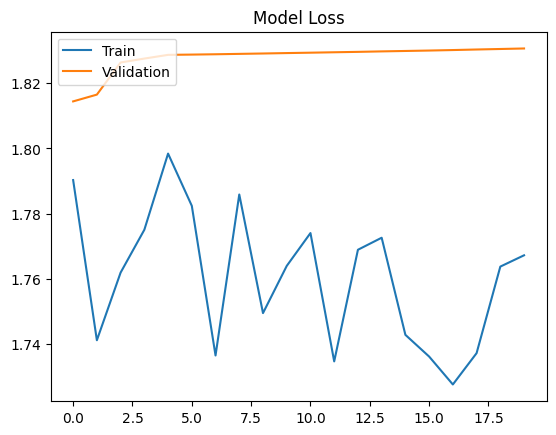

In [26]:
# Plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

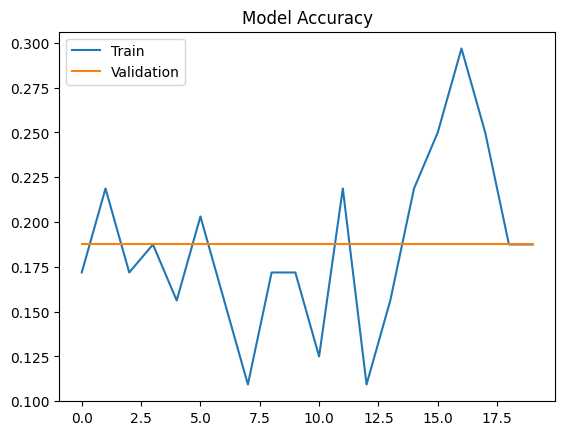

In [27]:
# Plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
# Save the combined model architecture
combined_model_json = combined_model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(combined_model_json)